In [1]:
%matplotlib inline
# import some useful modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
import os.path
import urllib
import altair as alt
import folium
import json

/home/mhagdorn/miniconda3/envs/EdTraffic/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# load the data from https://www.dft.gov.uk/traffic-counts/cp.php?la=City+of+Edinburgh
DATA_URL = 'http://api.dft.gov.uk/v3/trafficcounts/export/la/City+of+Edinburgh.csv'
dname = os.path.basename(DATA_URL)
if not os.path.exists(dname):
    urllib.urlretrieve(DATA_URL,dname)

In [3]:
# load the data into a pandas frame
aadf = pd.read_csv('City+of+Edinburgh.csv')

In [4]:
def addGeometry(data):
    geometry = [Point(xy) for xy in zip(data.Easting, data.Northing)]
    gdata = data.drop(['Easting','Northing'],axis=1)
    gdata = gpd.GeoDataFrame(gdata, crs={'init': 'epsg:27700'}, geometry=geometry)
    gdata=gdata.to_crs({'init': 'epsg:4326'})
    return gdata

In [12]:
def plotData(data,all=True):
    df = pd.DataFrame()
    if all:
        cols = ['PedalCycles','Motorcycles','CarsTaxis','BusesCoaches', 'LightGoodsVehicles','AllHGVs']
    else:
        cols = ['CarsTaxis','AllHGVs']
    for column in cols:
        d = data[['AADFYear',column,'Estimation_method']]
        d['type'] = column
        d.rename(columns = {column:'count'}, inplace = True)
        df = df.append(d,ignore_index=True)   
    c = alt.Chart(df).mark_point().encode(
        alt.X('AADFYear:T', timeUnit='year'),
        alt.Y('count'),
        color='type',
        shape='Estimation_method'
    )
    return c

In [6]:
c=plotData(aadf[aadf.CP==703])

/home/mhagdorn/miniconda3/envs/EdTraffic/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/mhagdorn/miniconda3/envs/EdTraffic/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


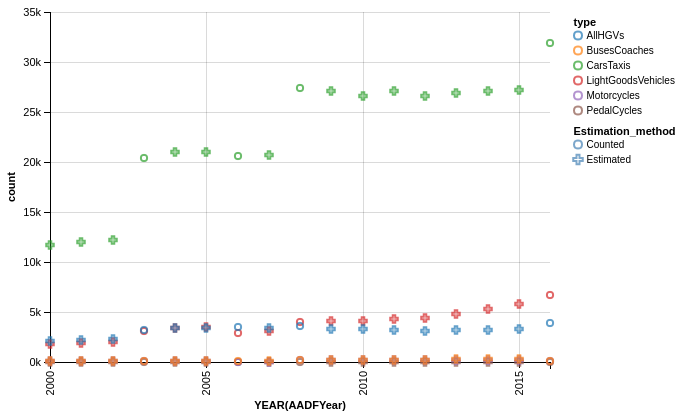

In [7]:
c

Index(['AADFYear', 'CP', 'Estimation_method', 'Estimation_method_detailed',
       'Region', 'LocalAuthority', 'Road', 'RoadCategory', 'Easting',
       'Northing', 'StartJunction', 'EndJunction', 'LinkLength_km',
       'LinkLength_miles', 'PedalCycles', 'Motorcycles', 'CarsTaxis',
       'BusesCoaches', 'LightGoodsVehicles', 'V2AxleRigidHGV',
       'V3AxleRigidHGV', 'V4or5AxleRigidHGV', 'V3or4AxleArticHGV',
       'V5AxleArticHGV', 'V6orMoreAxleArticHGV', 'AllHGVs', 'AllMotorVehicles',
       'geometry'],
      dtype='object')

In [27]:
pos = addGeometry(aadf[['CP','Easting','Northing']].drop_duplicates())

map = folium.Map(
    location=[55.9533,-3.1883],
    zoom_start=12,
    tiles='openstreetmap'
)

for r in pos.iterrows():
    print (r[1]['CP'],end=" ")
    d = aadf[aadf.CP == r[1]['CP']][['AADFYear','AllMotorVehicles']]
    change = d.iloc[-1].AllMotorVehicles-d.iloc[0].AllMotorVehicles
    if change < 0:
        color='green'
    else:
        color='red'
    c=plotData(aadf[aadf.CP==r[1]['CP']],all=True)
    folium.Marker(
        location=[r[1]['geometry'].y,r[1]['geometry'].x],
        icon=folium.Icon(color=color),
        popup=folium.Popup(max_width=450).add_child(
        folium.VegaLite(c, width=450, height=250))
    ).add_to(map)
print()

703 

/home/mhagdorn/miniconda3/envs/EdTraffic/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mhagdorn/miniconda3/envs/EdTraffic/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


1006 1012 1015 1150 1151 1205 10817 10822 10825 10850 10962 20702 20793 20821 20824 20958 20959 21015 21024 30816 30821 30827 30850 30872 30963 31017 31023 40814 40819 40823 40851 40877 40962 41015 50714 50717 50749 50854 50900 50901 50939 50951 50959 74288 74289 74303 74369 74382 74383 74385 74390 74391 74392 74394 77120 78567 78568 78569 78570 78575 80107 80108 80116 80117 80118 80121 80123 80126 80127 80140 80160 80161 80162 80163 80320 80394 80578 80579 80590 80592 80601 80602 74385 81479 81480 81481 20824 80578 


In [28]:
map.save('map.html')